https://www.kaggle.com/competitions/share2022mlcomp02

# Get data

Каждое решение должно иметь название формата "Фамилия_имя", другие решения не принимаются.

Победители должны будут предоставить код, показывающий, как было получено их решение, и презентацию решения.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! cd /content/drive/MyDrive/kaggle/

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle/"

In [ ]:
!kaggle competitions download -c share2022mlcomp02

 82% 38.0M/46.2M [00:00<00:00, 40.0MB/s]
100% 46.2M/46.2M [00:00<00:00, 53.6MB/s]


In [ ]:
! unzip share2022mlcomp02.zip

Archive:  share2022mlcomp01.zip
  inflating: sample_sabmission.csv   
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

ytrain = train['f291']
train = train.drop('id', axis=1)
train = train.drop('f291', axis=1)
test = test.drop('id', axis=1)

In [ ]:
train

In [ ]:
test.head()

# Preprocessing

Данное тестовое задание состоит в том, чтобы по набору примеров многомерных признаков и правильных ответов из обучающего множества обучить регрессионную модель, которую затем применить к набору примеров признаков из тестового множества и прислать файл с полученными ответами.

Для оценки качества работы алгоритма регрессии используется метрика RMSLE (Root Mean Squared Logarithmic Error)

In [ ]:
test.loc[0][train.dtypes.index[train.dtypes == object]] #get [0] element object columns

f1                2014-03-29
f11            OwnerOccupier
f12     Poselenie Vnukovskoe
f29                       no
f33                       no
f34                       no
f35                       no
f36                       no
f37                       no
f38                       no
f39                       no
f40                       no
f106                      no
f114                      no
f118                      no
f152                 no data
Name: 0, dtype: object

In [ ]:
train['f33'].unique()

array(['no', 'yes'], dtype=object)

In [ ]:
# f152 has gradation, not category. Better to make a gradation
#['good', 'no data', 'satisfactory', 'poor', 'excellent']
a = np.zeros(len(train), dtype=int)
for i, cond in enumerate(['no data', 'poor', 'satisfactory', 'good', 'excellent']):
    a += i*np.array(train['f152'] == cond)
#np.all(a[train['f152'] == 'excellent'] == 4)
train['f152'] = a

a = np.zeros(len(test), dtype=int)
for i, cond in enumerate(['no data', 'poor', 'satisfactory', 'good', 'excellent']):
    a += i * np.array(test['f152'] == cond)
test['f152'] = a

# f1 is a date Not category either
# I want them to be sorted and i havn't found it in ordinal encoder, sorted(train['f1'].unique()) seem to work
#but dates in train and test are different -> set|  only 1161 dates for 24376 rows
dates = set.union(set(train['f1'].unique()), set(test['f1'].unique()))
dates = sorted(dates)

a = np.zeros(len(train), dtype=int)
for i, date in enumerate(dates):#here we go up the date and it's number
    a += i*np.array(train['f1'] == date)
train['f1'] = a

a = np.zeros(len(test), dtype=int)
for i, date in enumerate(dates):
    a += i*np.array(test['f1'] == date)
test['f1'] = a

In [ ]:
#change yes/no columns to 1/0 columns (no nan here)
#no idea why not automatically, mb skip later
for ind in ['f29', 'f33','f34','f35','f36','f37','f38','f39','f40','f106','f114','f118' ]:
    train[ind] = 1*np.array(train[ind] == 'yes')

for ind in ['f29', 'f33','f34','f35','f36','f37','f38','f39','f40','f106','f114','f118' ]:
    test[ind] = 1*np.array(test[ind] == 'yes')

train['f11'] = 1*np.array(train['f11'] == 'OwnerOccupier')
test['f11'] = 1*np.array(test['f11'] == 'OwnerOccupier')

In [ ]:
#only Juzhnoe Butovo 'f12' is left
#try one hot and ordinal encoders
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

encoder = OrdinalEncoder()
newf12tr = encoder.fit_transform(train['f12'][..., np.newaxis])
train['f12'] = newf12tr.squeeze()

newf12t = encoder.transform(test['f12'][..., np.newaxis])
test['f12'] = newf12t.squeeze()

#encoder.categories_

In [ ]:
#knn imputer deletes headers, so we have to do smth to save them
from sklearn.impute import KNNImputer, MissingIndicator

ind = MissingIndicator()
miss = ind.fit_transform(train)
#this is np.all(miss == missing) == True what is being added in KnnImputer
#len(nancols) = 51
nancols = []
for name in train.columns[ind.features_]:
    nancols.append(name+'nan')
newcols = [*train.columns]+nancols

# ind = MissingIndicator()
# miss = ind.fit_transform(test)
#in test the columns are the same

In [ ]:
#Nan with nn cause i like them)
# KNNImputer потому что этот способ вставить значения
# куда лучше,чем просто какое либо среднее, но в то же время не слишком сложный

imputer = KNNImputer(n_neighbors=5, add_indicator=True)
tr = imputer.fit_transform(train)
train = pd.DataFrame(tr, columns = newcols)

imputer = KNNImputer(n_neighbors=5, add_indicator=True)
t = imputer.fit_transform(test)
test = pd.DataFrame(t, columns = newcols)
#флаги пропусков это хорошо(и корелляция пропусков)
#TRY with and without

In [ ]:
train

In [ ]:
#save new train and test cause knn is slow
#with nan flags and ordinal f12
#and ytrain glued back to train)
train['y'] = ytrain
train.to_csv('trainNew.csv', index = False)
test.to_csv('testNew.csv', index = False)

In [ ]:
!	cp trainNew.csv /content/drive/MyDrive/kaggle/
!	cp testNew.csv /content/drive/MyDrive/kaggle/

In [ ]:
! cp /content/drive/MyDrive/kaggle/*New.csv .

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

#to load them back
train = pd.read_csv('trainNew.csv')
test = pd.read_csv('testNew.csv')

ytrain = train['y']
train = train.drop('y', axis=1)

In [ ]:
len(train.columns)

341

In [ ]:
train

test our preprocessing

In [ ]:
#нормировать надо mb!!!
#еще можно бы смотреть на данные
#корелляция пропусков
#(равномерность классов, корелляция,логистическая регрессия для ненужнвх фич?????,
#как то(кросс валидация; kfold) люди поняли, что первые 10к битые)

In [ ]:
#КРАСИВЫЕ КАРТИНКИИИИИИИИИ

In [ ]:
#f12 is ordinal and f11 can be reversed and nan flags skipped

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_sc = scaler.fit_transform(train)
test_sc = scaler.transform(test)

In [ ]:
trcols = np.array(train_sc).T
cov = np.cov(trcols)

In [ ]:
def trash(trashhold):
    c = cov>trashhold
    d = set()
    l = len(train.columns)
    for i in range(l):
        for j in range(i+1, l):
            if c[i][j]:
                d.add(i)
                break
    return d
#d

In [ ]:
len(trash(0.9))

0

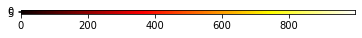

In [ ]:
a = np.arange(0,1,0.001)
plt.imshow(np.vstack([a]*10), cmap='hot')
plt.show()

In [ ]:
#for dropped
scaler = StandardScaler()
td_sc = scaler.fit_transform(tr_dr)

trcols = np.array(td_sc).T
covd = np.cov(trcols)

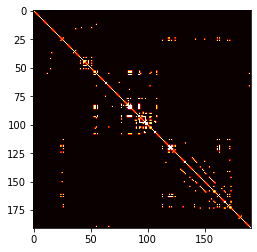

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
plt.imshow(cov>0.8, cmap='hot')
#plt.savefig('cov.png', dpi = 256)
plt.show()

In [ ]:
d = train.columns[[*trash(0.99)]]
tr_dr = train.drop(d, axis=1)
t_dr = test.drop(d, axis=1)
#, inplace=True

In [ ]:
len(tr_dr.columns)

234

In [ ]:
tr_dr

logistic regression check:

Для оценки качества работы алгоритма регрессии используется метрика RMSLE (Root Mean Squared Logarithmic Error)

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html

In [ ]:
from sklearn.metrics import mean_squared_log_error
#mean_squared_log_error(y_true, y_pred,squared=False)
from sklearn.linear_model import LinearRegression, ElasticNet

In [ ]:
#for logistic regression we need scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
td_sc = scaler.fit_transform(tr_dr)

In [ ]:
# 0.5334973008499887
scaler = StandardScaler()
train_sc = scaler.fit_transform(train)

model = ElasticNet(positive = True)
model.fit(train_sc[:10000], ytrain[:10000])
y = model.predict(train_sc)
#y[y < 0] = 0
mean_squared_log_error(ytrain, y, squared=False)

0.5334973008499887

In [ ]:
#without nan indicators 0.5334973008495185
scaler = StandardScaler()
train_sc = scaler.fit_transform(train.iloc[:, :290])

model = ElasticNet(positive = True)
model.fit(train_sc[:10000], ytrain[:10000])
y = model.predict(train_sc)
y[y < 0] = 0
mean_squared_log_error(ytrain, y, squared=False)

0.5334973008495185

In [ ]:
#with f12 as one hot instead of ordinal 0.5224133022905805
from sklearn.preprocessing import OneHotEncoder

# enc = OneHotEncoder(handle_unknown='ignore')
# f12 = enc.fit_transform(train['f12'][..., np.newaxis])
# troh = train.drop('f12', axis=1)
# f12 = pd.DataFrame(f12.toarray(), columns = [str(i)+'oh' for i in range(146)])
# troh = pd.concat([troh,f12],  axis=1)

scaler = StandardScaler()
train_sc = scaler.fit_transform(train)

model = ElasticNet(positive = True)
model.fit(train_sc[:10000], ytrain[:10000])
y = model.predict(train_sc)
#y[y < 0] = 0
mean_squared_log_error(ytrain, y, squared=False)

0.5224133022905805

In [ ]:
troh

In [ ]:
#without correlated features
# 0.93 : 0.5340022766068765
# 0.94 : 0.5340022766068765
# 0.95 : 0.5335577057159869
# 0.97 : 0.5334861672390546
# 0.98 : 0.5334861672390546
# 0.99 : 0.5334170205536763
# 1    : 0.5334973008498826
# 1.1  : 0.5334973008499887
for trashhold in [0.93,0.94,0.95,0.97,0.98, 0.99, 1, 1.1]:
    d = train.columns[[*trash(trashhold)]]
    tr_dr = train.drop(d, axis=1)

    scaler = StandardScaler()
    td_sc = scaler.fit_transform(tr_dr)

    model = ElasticNet(positive = True)
    model.fit(td_sc[:10000], ytrain[:10000])
    y = model.predict(td_sc)
    y[y < 0] = 0
    err = mean_squared_log_error(ytrain, y, squared=False)
    print(trashhold, ':', err)

0.93 : 0.5334086482169713
0.94 : 0.5334086482168587
0.95 : 0.5334330909495241
0.97 : 0.5333759396698627
0.98 : 0.5334229953447789
0.99 : 0.5334973008499887
1 : 0.5334973008499887
1.1 : 0.5334973008499887


automatic feature selector

In [ ]:
#with thing for feature selection automatically + corr drop at 0.99
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import OneHotEncoder

# enc = OneHotEncoder(handle_unknown='ignore')
# f12 = enc.fit_transform(train['f12'][..., np.newaxis])
# troh = train.drop('f12', axis=1)
# f12 = pd.DataFrame(f12.toarray(), columns = [str(i)+'oh' for i in range(146)])
# troh = pd.concat([troh,f12],  axis=1)

d = train.columns[[*trash(0.99)]]
tr = train.drop(d, axis=1)

scaler = StandardScaler()
train_sc = scaler.fit_transform(tr)

selector = RFECV(ElasticNet(positive = True), scoring='neg_mean_squared_log_error', step = 15)
selector = selector.fit(train_sc[:10000], ytrain[:10000])

print(selector.support_)
print(selector.ranking_)


In [ ]:
np.sum(selector.support_)

24

In [ ]:
print(f"Optimal number of features: {selector.n_features_}")
np.save('selected_features', selector.ranking_)

Optimal number of features: 24


In [ ]:
!	cp selected_features.npy /content/drive/MyDrive/kaggle/

In [ ]:
np.save('selected_features', tr.columns[selector.support_])

In [ ]:
!	cp selected_features.npy /content/drive/MyDrive/kaggle/

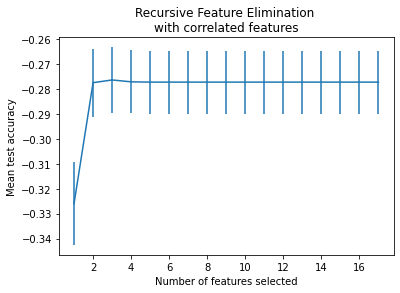

In [ ]:
import matplotlib.pyplot as plt

n_scores = len(selector.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(1, n_scores + 1),
    selector.cv_results_["mean_test_score"],
    yerr=selector.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.savefig("pict.png")
plt.show()

In [ ]:
!	cp pict.png /content/drive/MyDrive/kaggle/

In [ ]:
sel = tr.columns[selector.support_]
sel

Index(['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f8', 'f10', 'f11', 'f19', 'f22',
       'f24', 'f25', 'f51', 'f73', 'f84', 'f120', 'f173', 'f208', 'f266',
       'f271', 'f273', 'f287', 'f289'],
      dtype='object')

In [ ]:
#0.0.6215011668142395
tr = train[sel]

scaler = StandardScaler()
train_sc = scaler.fit_transform(tr)

model = ElasticNet()
model.fit(tr[:10000], ytrain[:10000])
y = model.predict(tr)
y[y<0] = 0
mean_squared_log_error(ytrain, y, squared=False)

0.6215011668142395

лучшие - one hot и 0.99 корелляция

# load data and preprocess fast


кросс валидация

In [ ]:
! cp /content/drive/MyDrive/kaggle/*New.csv .

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

#to load them back
train = pd.read_csv('trainNew.csv')
test = pd.read_csv('testNew.csv')

ytrain = train['y']
train = train.drop('y', axis=1)

In [ ]:
#0.5100937368072971
from sklearn.metrics import mean_squared_log_error#(y_true, y_pred,squared=False)
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.preprocessing import StandardScaler, OneHotEncoder

scaler = StandardScaler()
train_sc = scaler.fit_transform(train)
trcols = np.array(train_sc).T
cov = np.cov(trcols)

c = cov>0.99
d = set()
l = len(train.columns)
for i in range(l):
    for j in range(i+1, l):
        if c[i][j]:
            d.add(i)
            break
d = train.columns[[*d]]
train = train.drop(d, axis=1)
test = test.drop(d, axis=1)

enc = OneHotEncoder(handle_unknown='ignore')
f12 = enc.fit_transform(train['f12'][..., np.newaxis])
f12t = enc.transform(test['f12'][..., np.newaxis])
train = train.drop('f12', axis=1)
test = test.drop('f12', axis=1)
f12 = pd.DataFrame(f12.toarray(), columns = [str(i)+'oh' for i in range(146)])
f12t = pd.DataFrame(f12t.toarray(), columns = [str(i)+'oh' for i in range(146)])
train = pd.concat([train,f12],  axis=1)
test = pd.concat([test,f12t],  axis=1)

scaler = StandardScaler()
train_sc = scaler.fit_transform(train)
test_sc = scaler.transform(test)

model = ElasticNet(positive = True, l1_ratio=0.888)
model.fit(train_sc[:10000], ytrain[:10000])
y = model.predict(train_sc)
# model.fit(train_sc, ytrain)
# y = model.predict(train_sc)
mean_squared_log_error(ytrain, y, squared=False)

<ipython-input-4-ec9a3d6e8c60>:24: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  f12 = enc.fit_transform(train['f12'][..., np.newaxis])
<ipython-input-4-ec9a3d6e8c60>:25: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  f12t = enc.transform(test['f12'][..., np.newaxis])


0.5100937368072971

In [ ]:
#ПЕРЕПИСАТЬ ЧЕРЕЗ МЕТРИКУ, А НЕ abs и считать статистики по всему, плохому и не плохому
#df.describe() std это стандартное отклонение The 50 percentile is the same as the median
a = np.array([mean_squared_log_error([ytrain[i]], [el], squared=False) for i, el in enumerate(y)])
#len(a) = 24376
#np.sum(a>0.4) 4163
#np.sum(a<0.4) 20213

In [ ]:
np.sum(a>0.8)

2103

In [ ]:
len(a)

24376

ТАМ ДЕВОЧКА ЛОГАРИФМИРОВАЛА ДАННЫЕ
ТОП ТЕМА

In [ ]:
g = ytrain[a>0.7].describe(percentiles=[0.1,0.5,0.9])
for i, val in enumerate(g):
    print(g.index[i], ':', f'{val:,.0f}')

count : 2,319
mean : 4,227,430
std : 9,871,674
min : 100,000
10% : 1,000,000
50% : 2,000,000
90% : 4,900,000
max : 111,111,112


In [ ]:
g = ytrain[a<0.7].describe(percentiles=[0.1,0.5,0.9])
for i, val in enumerate(g):
    print(g.index[i], ':', f'{val:,.0f}')

count : 22,057
mean : 7,429,370
std : 3,828,102
min : 990,000
10% : 4,035,811
50% : 6,500,000
90% : 11,950,000
max : 58,200,000


In [ ]:
g = (ytrain[a>0.7] *2 + 2000000).describe(percentiles=[0.1,0.5,0.9])
for i, val in enumerate(g):
    print(g.index[i], ':', f'{val:,.0f}')

count : 2,319
mean : 10,454,861
std : 19,743,348
min : 2,200,000
10% : 4,000,000
50% : 6,000,000
90% : 11,800,000
max : 224,222,224


In [ ]:
# instead of 0.51 it gives 0.48
ynew = ytrain*(a<0.7) + (ytrain*2+2000000)*(a>0.7)

model = ElasticNet(positive = True, l1_ratio=0.888)
model.fit(train_sc[:10000], ynew[:10000])
y = model.predict(train_sc)
y[y<0] = 0
print(np.sum(y<0))
mean_squared_log_error(ynew, y, squared=False)

0


0.48663579319757555

In [ ]:
bad = train[a>0.7].describe()
norm = train[a<0.7].describe()
all = train.describe()
bad.insert(0, 'id', 'bad')
norm.insert(0, 'id', 'norm')
all.insert(0, 'id', 'all')

descr = pd.concat([bad, norm, all], axis = 0)
descr.insert(0, 'what', descr.index)
descr.sort_values( ['what', 'id'], ascending=True, inplace=True, ignore_index = True)

In [ ]:
descr.T.to_csv('stat.csv', index=True, header=False)

In [ ]:
descr

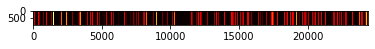

1895

In [ ]:
import matplotlib.pyplot as plt

s = a > 0.9
plt.imshow(np.vstack([s]*1000), cmap='hot')
plt.show()
np.sum(s)

In [ ]:
train[s]
#train[s].to_csv('regfailed.csv', index = False)

In [ ]:
np.max(train['f18'])

11926.0

# Model training

hyperparameter search

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV

X_train, X_val, y_train, y_val = train_test_split(train_sc, ynew, test_size=0.16)


In [ ]:
#0.42332076951073994
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(n_estimators=400, max_depth=70)#, random_state=0
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=70, n_estimators=400)

In [ ]:
y = model.predict(X_val)
#y[y<0] = 0
mean_squared_log_error(y_val, y, squared=False)

0.42332076951073994

In [ ]:
#ElasticNet(positive = True, l1_ratio=0.888)
# 0.0 : 0.5353040837119386
# 0.1 : 0.5330254121812485
# 0.2 : 0.5305925748424504
# 0.3 : 0.5280084677073636
# 0.4 : 0.5252725542466168
# 0.5 : 0.5223469822042291
# 0.6 : 0.5191845658257048
# 0.7 : 0.5157912232856665
# 0.8 : 0.5122510925007232
# 0.85 : 0.510686357128742
# 0.86 : 0.5104450780084111
# 0.87 : 0.5102520940323241
# 0.88 : 0.5101254066410246
# 0.881 : 0.5101179039911347
# 0.882 : 0.5101113176607251
# 0.883 : 0.5101054440713395
# 0.884 : 0.5101007426869558
# 0.885 : 0.5100972765554408
# 0.886 : 0.5100951144613595
# 0.887 : 0.5100939946035224
# 0.888 : 0.5100937368072971
# 0.889 : 0.5100950252155232
# 0.89 : 0.5100979149787173
# 0.891 : 0.5101024602142079
# 0.892 : 0.5101089940601982
# 0.893 : 0.5101180228707133
# 0.894 : 0.5101293443591045
# 0.895 : 0.5101431687682101
# 0.896 : 0.5101597438307357
# 0.897 : 0.5101793655636335
# 0.898 : 0.510202393435113
# 0.899 : 0.5102292722837671
# 0.9 : 0.5102605649522625

for rat in np.arange(0.88,0.9,0.001):
    model= ElasticNet(positive = True, l1_ratio=rat)
    model.fit(X_train, y_train)
    y = model.predict(X_val)
    y[y<0] = 0
    print("%.3f" % rat, ':', mean_squared_log_error(y_val, y, squared=False))

In [ ]:
#0.8124080840269065
from sklearn.linear_model import ARDRegression

model= ARDRegression()
model.fit(X_train, y_train)
y = model.predict(X_val)
y[y<0] = 0
mean_squared_log_error(y_val, y, squared=False)

0.8124080840269065

In [ ]:
#0.5013560894161813
from sklearn.linear_model import PassiveAggressiveRegressor

model= PassiveAggressiveRegressor()
model.fit(X_train, y_train)
y = model.predict(X_val)
y[y<0] = 0
mean_squared_log_error(y_val, y, squared=False)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0.5013560894161813

In [ ]:
#model = SVR(kernel = 'linear', epsilon = 0.04)
#standart 0.6043703894656486
from sklearn.svm import SVR
#many parameters
# 0.010 : 0.5940757898018487
# 0.020 : 0.5940757897983511
# 0.030 : 0.5940757897929786
# 0.040 : 0.5940757897864204

for eps in np.arange(0.01,0.05,0.01):
    model = SVR(kernel = 'linear', epsilon = eps)
# params = {'kernel': [ 'linear', 'poly', 'rbf', 'sigmoid'], 'epsilon': np.arange(0.05, 0.5, 0.05)}
# search = RandomizedSearchCV(model, params, n_iter = 20, scoring = 'neg_mean_squared_log_error')
# s = search.fit(X_train, y_train)
# s.best_params_ , s.best_score_
# ({'kernel': 'linear', 'epsilon': 0.05}, -0.3565850083159148) = 0.5940757897798622 ну такое
# sres[sres['param_kernel'] == 'linear'].sort_values( 'rank_test_score', ascending=True)
# 'linear' лучше всех - все первые тесты его и чем меньше эпсилон, тем лучше
    model.fit(X_train, y_train)
    y = model.predict(X_val)
    y[y<0] = 0
    print("%.3f" % eps, ':', mean_squared_log_error(y_val, y, squared=False))

0.010 : 0.5940757898018487
0.020 : 0.5940757897983511
0.030 : 0.5940757897929786
0.040 : 0.5940757897864204


In [ ]:
#0.5036997792176893
from sklearn.neighbors import KNeighborsRegressor

# model = KNeighborsRegressor(weights = 'distance', metric = 'euclidean')
# params = {'n_neighbors': [*range(1,20,1)]}#, 'metric': ['minkowski', 'cosine', 'cityblock', 'euclidean', 'manhattan']}
# search = RandomizedSearchCV(model, params, n_iter = 10, scoring = 'neg_mean_squared_log_error')
# s = search.fit(X_train, y_train)
# s.best_params_ , s.best_score_

model = KNeighborsRegressor(n_neighbors = 8, weights = 'distance', metric = 'euclidean')
model.fit(X_train, y_train)
y = model.predict(X_val)
y[y<0] = 0
mean_squared_log_error(y_val, y, squared=False)

0.5036997792176893

In [ ]:
#1.7738302200319234 очень плохо
from sklearn.neural_network import MLPRegressor
#let me try

model = MLPRegressor(solver='adam')
model.fit(X_train, y_train)
y = model.predict(X_val)
y[y<0] = 0
mean_squared_log_error(y_val, y, squared=False)

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1.7738302200319234

In [ ]:
#0.46113359548012406 max_depth=10
#0.4578445583729132
from sklearn.ensemble import HistGradientBoostingRegressor

model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)
y = model.predict(X_val)
y[y<0] = 0
mean_squared_log_error(y_val, y, squared=False)

0.4578445583729132

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import PassiveAggressiveRegressor, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor

In [ ]:
r1 = RandomForestRegressor(n_estimators=400, max_depth=70)
r2 = ElasticNet(positive = True, l1_ratio=0.888)
r3 = PassiveAggressiveRegressor()
r4 = SVR(kernel = 'linear', epsilon = 0.04)
r5 = KNeighborsRegressor(n_neighbors = 8, weights = 'distance', metric = 'euclidean')
r6 = HistGradientBoostingRegressor()
regressors = [('r1', r1), ('r2', r2), ('r3', r3), ('r4', r4), ('r5', r5), ('r6', r6)]

model = StackingRegressor(estimators = regressors, final_estimator = HistGradientBoostingRegressor())
model.fit(train_sc, ynew)
y = model.predict(X_val)
y[y<0] = 0
mean_squared_log_error(y_val, y, squared=False)
#0.2854461082821771
#0.12586741473941643 with altered data

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_

0.12586741473941643

#end

In [ ]:
y = model.predict(test_sc)

In [ ]:
df = pd.DataFrame({'id': [*range(1,len(y)+1)], 'prediction': ["%.1f" % a for a in y]})
df.to_csv('Козырева_Елизавета.csv', index = False)

In [ ]:
!	cp Козырева_Елизавета.csv /content/drive/MyDrive/kaggle/

все делали катбуст

вникнуть в данные это хорошо

результат логарифмировали и получали больше

чел добавил рандомную фичу и дропнул признаки, которые ниже полезность(корелляцию с результатом) дали

байесовская оптимизация гиперпараметров

zscore для выбросов
матожидание + 3 квадратичных отклонения

чел заменял район на среднюю цену в нем

2 чела уже делили данные на отдельно инвестора, а отдельно оккупайера

чел сильно кореллировал с тем, что на недвижимость
и делал дату как разницу до сейчас

и смотрел фиче импортанс
и 2750 деревьев!!!!!
